In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from helper_funcs import *

In [2]:
zipdata = get_zipdata()
RF = get_redfin_csv()

----pulling ZipCode data from Azure storage----
----Done----
----pulling Redfin data from Azure storage----
----Done----


In [3]:
RF = RF.groupby('zip').agg('mean')[['PRICE']]
RF = RF.merge(zipdata, how='left', left_index=True, right_index=True).drop(columns='AverageHouseValue')

In [4]:
for i,each in enumerate(RF.columns):
    print(f'{i}: {each}')

0: PRICE
1: Population
2: HouseholdsPerZipCode
3: IncomePerHousehold
4: MedianAge
5: NumberOfBusinesses
6: over_65_ratio
7: school_rating
8: Hosp_count
9: HPI
10: Demand_score
11: Supply_score
12: listviews_vs_US
13: med_days_on_mkt
14: nielson_rank
15: UE_rate
16: Zillow_HVF
17: BEA_percap_income
18: Blacks_ratio
19: Hispanics_ratio
20: Asians_ratio
21: Indians_ratio
22: Others_ratio
23: Male_ratio


<AxesSubplot:>

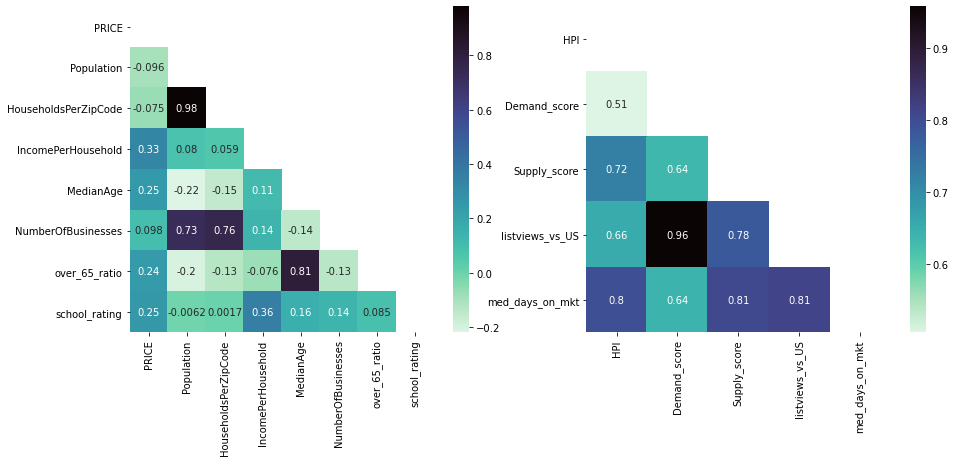

In [5]:
corr1 = RF.iloc[:,0:8].corr()
corr2 = RF.iloc[:,9:14].corr()

mask1 = np.triu(np.ones_like(corr1, dtype=bool)) # Hide upper redundant heatmap
mask2 = np.triu(np.ones_like(corr2, dtype=bool)) # Hide upper redundant heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(corr1, mask=mask1, ax=ax[0], annot=True, cmap='mako_r')
sns.heatmap(corr2, mask=mask2, ax=ax[1], annot=True, cmap='mako_r')

<AxesSubplot:>

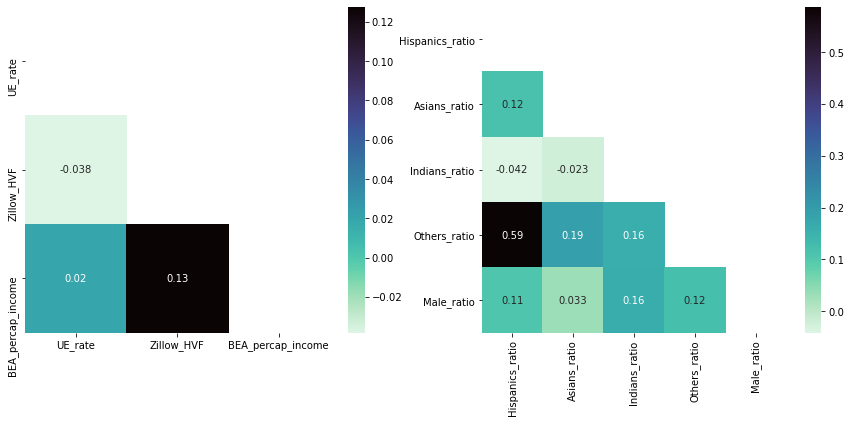

In [6]:
corr1 = RF.iloc[:,15:18].corr()
corr2 = RF.iloc[:,19:].corr()

mask1 = np.triu(np.ones_like(corr1, dtype=bool)) # Hide upper redundant heatmap
mask2 = np.triu(np.ones_like(corr2, dtype=bool)) # Hide upper redundant heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(corr1, mask=mask1, ax=ax[0], annot=True, cmap='mako_r')
sns.heatmap(corr2, mask=mask2, ax=ax[1], annot=True, cmap='mako_r')

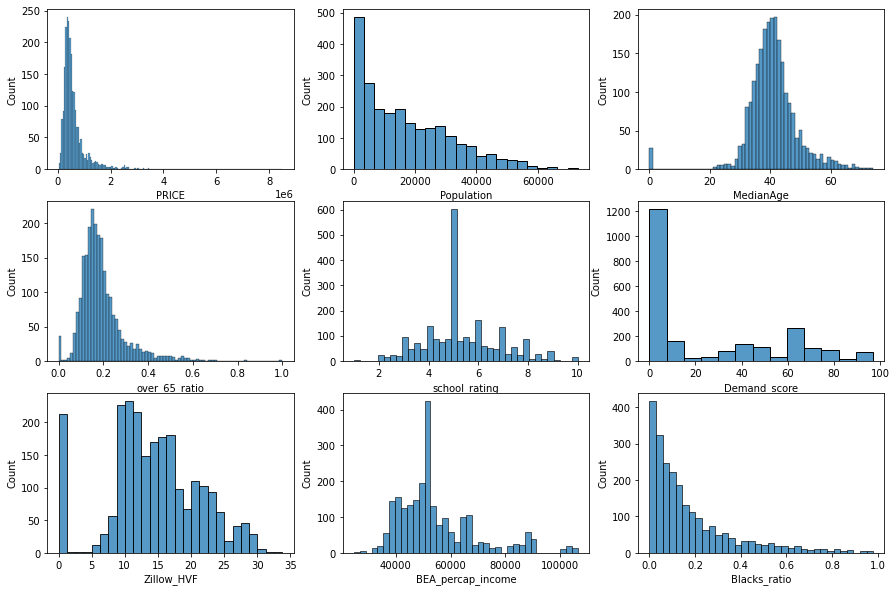

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))

sns.histplot(ax=axs[0,0], x=RF.PRICE)
sns.histplot(ax=axs[0,1], x=RF.Population)
sns.histplot(ax=axs[0,2], x=RF.MedianAge)
sns.histplot(ax=axs[1,0], x=RF.over_65_ratio)
sns.histplot(ax=axs[1,1], x=RF.school_rating)
sns.histplot(ax=axs[1,2], x=RF.Demand_score)
sns.histplot(ax=axs[2,0], x=RF.Zillow_HVF)
sns.histplot(ax=axs[2,1], x=RF.BEA_percap_income)
sns.histplot(ax=axs[2,2], x=RF.Blacks_ratio);

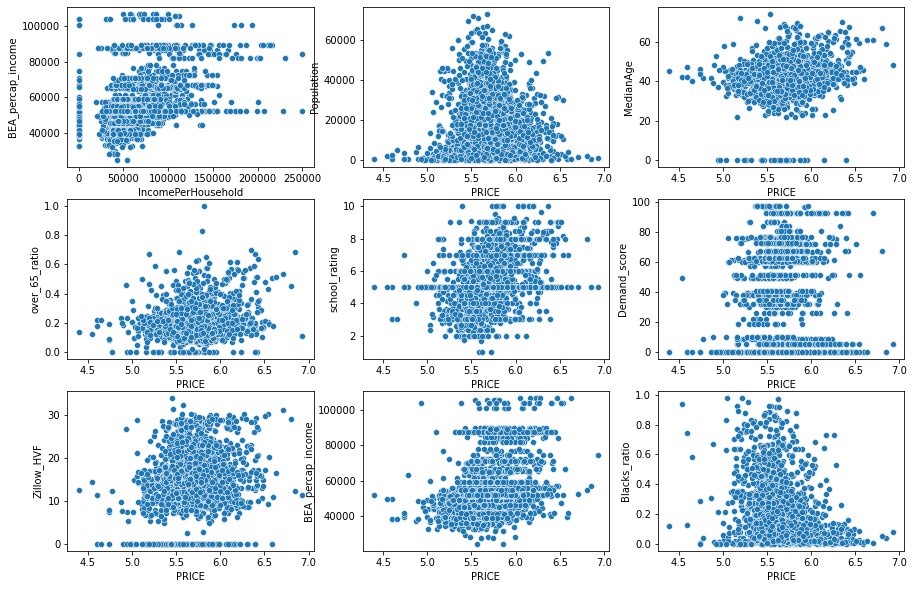

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))

sns.scatterplot(ax=axs[0,0], x=RF.IncomePerHousehold, y=RF.BEA_percap_income)
sns.scatterplot(ax=axs[0,1], x=np.log10(RF.PRICE), y=RF.Population)
sns.scatterplot(ax=axs[0,2], x=np.log10(RF.PRICE), y=RF.MedianAge)
sns.scatterplot(ax=axs[1,0], x=np.log10(RF.PRICE), y=RF.over_65_ratio)
sns.scatterplot(ax=axs[1,1], x=np.log10(RF.PRICE), y=RF.school_rating)
sns.scatterplot(ax=axs[1,2], x=np.log10(RF.PRICE), y=RF.Demand_score)
sns.scatterplot(ax=axs[2,0], x=np.log10(RF.PRICE), y=RF.Zillow_HVF)
sns.scatterplot(ax=axs[2,1], x=np.log10(RF.PRICE), y=RF.BEA_percap_income)
sns.scatterplot(ax=axs[2,2], x=np.log10(RF.PRICE), y=RF.Blacks_ratio);

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

### TRY PCAs again:

Not Included: Zillow, School_rating, Hosp, AverageHouseValue

In [10]:
all_feats = ['Population', 'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 
             'Indians_ratio', 'Others_ratio', 'Male_ratio', 'MedianAge', 'over_65_ratio', 
             'BEA_percap_income', 'NumberOfBusinesses', 
             'UE_rate', 'HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US', 
             'med_days_on_mkt', 'nielson_rank']

In [11]:
mms = MinMaxScaler()
# REMOVE AverageHouseValue
data_scaled = pd.DataFrame(mms.fit_transform(RF.drop(columns='PRICE').values), 
                           columns=RF.drop(columns='PRICE').columns, 
                           index=RF.drop(columns='PRICE').index)

In [12]:
pca = PCA(n_components=0.8)
pca.fit(data_scaled[all_feats])
print(f'population PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
all_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[all_feats]), 
                        columns=['PCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=RF.index)

population PCA explained: [0.545 0.109 0.082 0.052 0.042]
number of PCA columns: 5


In [13]:
model_data = get_redfin_csv()
print(model_data.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


In [14]:
model_data = model_data.merge(all_PCAs, how = 'left', left_on = 'zip', right_index=True)

In [15]:
model_data.columns

Index(['Sale_Type', 'Sold_Date', 'Prop_Type', 'ADDRESS', 'CITY', 'State',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SF', 'Lot_Size', 'YearBuilt',
       'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE',
       'LONGITUDE', 'zip', 'Detached', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3',
       'PCA_4'],
      dtype='object')

In [18]:
model_data = model_data.merge(RF[['school_rating','Zillow_HVF','Hosp_count']], how = 'left', left_on = 'zip', right_index=True)

In [19]:
target_feats = ['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3','PCA_4', 'school_rating', 'Zillow_HVF']

lm = LinearRegression()
cat = CatBoostRegressor(verbose=False)

LM_train_R2 = []
LM_test_R2 = []

CAT_train_R2 = []
CAT_test_R2 = []

for i in range(5):
    X_train_dum, X_test_dum, X_train_le, X_test_le, y_train, y_test = get_train_test(model_data,target_feats)
    lm.fit(X_train_dum, y_train)
    LM_train_R2.append(lm.score(X_train_dum, y_train))
    LM_test_R2.append(lm.score(X_test_dum, y_test))
   
    cat.fit(X_train_le, y_train)
    CAT_train_R2.append(cat.score(X_train_le, y_train))
    CAT_test_R2.append(cat.score(X_test_le, y_test))
    print(i+1)

print(f'Linear Model train R2: {np.average(LM_train_R2)}')
print(f'Linear Model test R2: {np.average(LM_test_R2)}')
print(f'CatBoost train R2: {np.average(CAT_train_R2)}')
print(f'CatBoost Model test R2: {np.average(CAT_test_R2)}')

1
2
3
4
5
Linear Model train R2: 0.7543786730110651
Linear Model test R2: 0.7359679060435663
CatBoost train R2: 0.877504643314948
CatBoost Model test R2: 0.8472197630346393
